<a href="https://colab.research.google.com/github/benbezzina4/NLP2/blob/master/Colab_text_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# write your imports up here
import pandas as pd
import numpy as np
import torch
import io
from collections import Counter
import nltk
import sklearn
import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = 'cpu'

# Text compression assignment

You are to follow the instructions below and fill each cell as instructed.
Once ready, submit this notebook on VLE with all the outputs included (run all your code and don't clear any output cells).
Do not submit anything else apart from the notebook and do not use any extra data apart from what is provided.

10% of the marks from this assignment are based on neatness.

This assignment will carry 60% of the final mark.

## Introduction

It is said that you can measure the intelligence of an AI from the amount it can compress a text without information loss.
One way to think about this is that, the more a text is predictable, the more words we can leave out of it as we can guess the missing words.
On the other hand, the more intelligent an AI is, the more it will find texts to be predictable and so the more words it can leave out and guess.
This has led to a competition called the [Hutter Prize](http://prize.hutter1.net/) where the objective is to compress a given text as much as possible.
The record for compressing a 1GB text file extracted from a Wikipedia snapshot is about 115MB.
The main hurdle here is that the program used to decompress the file must be treated as part of the compressed file, meaning that the program itself must also be small.

In this assignment, we're going to be doing something similar using a smaller text file and using neural language models to guess missing words.

## Data processing (10%)

You have a train/dev/test split corpus of text from Wikipedia consisting of single sentences.
Each sentence is on a separate line and each sentence has been tokenised for you such that tokens are space separated.
This means that you only need to split by space to get the tokens.
The text has all been lowercased as well.
The objective here is to be able to compress the text losslessly, meaning that it can be decompressed back to the original string:

$$\text{decompress}(\text{compress}(t)) = t$$

Do not do any further pre-processing on the text (such as stemming) as it may result in unrecoverable information loss.
The test set is what we will be compressing and will not be processed at all as it will be treated as a single big string by the compression/decompression algorithms.

Do the following tasks:

Load the train set and dev set text files into a list of sentences where each sentence is tokenised (by splitting by space).

In [ ]:
def read_sentences_from_file(path_to_file):
    lines = []
    with io.open(path_to_file, mode="r", encoding='utf-8-sig') as file:
        for line in file:
            line = line.strip()
            if line != "":
                lines.append(line.strip())

    return lines

In [ ]:
train = read_sentences_from_file('/content/drive/MyDrive/Colab Notebooks/train.txt')
train_pd = pd.DataFrame(train,columns = ['text'])

test = read_sentences_from_file('/content/drive/MyDrive/Colab Notebooks/test.txt')
test_pd = pd.DataFrame(test,columns = ['text'])

dev = read_sentences_from_file('/content/drive/MyDrive/Colab Notebooks/dev.txt')
dev_pd = pd.DataFrame(dev,columns = ['text'])

In [ ]:
#Tokenizing sentences

train_pd['tok_text'] = train_pd.apply(lambda row: nltk.word_tokenize(row['text'].lower()), axis=1)
dev_pd['tok_text'] = dev_pd.apply(lambda row: nltk.word_tokenize(row['text'].lower()), axis=1)
test_pd['tok_text'] = test_pd.apply(lambda row: nltk.word_tokenize(row['text'].lower()), axis=1)

Extract a vocabulary consisting of the tokens that occur at least 3 times in the train set and output the size of your vocabulary.
Also output the most frequent vocabulary token in the train set, which should be 'the'.
Include the edge token, unknown token, and pad token in the vocabulary.

In [ ]:
word_counts = Counter(word for sent in train_pd['tok_text'] for word in sent)

vocab = []
most_freq_word_count = 0
most_freq_word = ""
for key in word_counts.keys():
    if word_counts[key] >= 3:
        vocab.append(key)
    if  word_counts[key] > most_freq_word_count:
        most_freq_word_count = word_counts[key]
        most_freq_word = key

    
#vocab = [key for key in word_counts.keys() if word_counts[key] >= 3]

vocab.append('<UNK>') #including unknown token
vocab.append('<PAD>') #including pad token
vocab.append('<EDGE>') #including pad token

print(most_freq_word,most_freq_word_count)

the 15548


Create a data set of indexified token sequences for the train set and dev set using the vocabulary created above in a way that is suitable for a language model, making use of edge tokens, unknown tokens, and pad tokens.

In [ ]:
#<UNK>
def apply_unk(sentence):
    unkenized_sent = []
    for word in sentence:
        if word in vocab:
            unkenized_sent.append(word)
        else:
            unkenized_sent.append("<UNK>")
    return unkenized_sent

In [ ]:
train_pd['tok_text'] = train_pd['tok_text'].apply(apply_unk)
test_pd['tok_text'] = test_pd['tok_text'].apply(apply_unk)
dev_pd['tok_text'] = dev_pd['tok_text'].apply(apply_unk)

In [ ]:
train_texts = train_pd['tok_text'].tolist()
test_texts = test_pd['tok_text'].tolist()
dev_texts = dev_pd['tok_text'].tolist()
vocab_dict = {k: v for v, k in enumerate(vocab)} #dict makes it more efficient

train_text_lens = torch.tensor([len(sent) + 1 for sent in train_texts], dtype=torch.int64,device=device) # Include the edge token.
test_text_lens = torch.tensor([len(sent) + 1 for sent in test_texts], dtype=torch.int64,device=device)
dev_text_lens = torch.tensor([len(sent) + 1 for sent in dev_texts], dtype=torch.int64,device=device)

train_max_len = max(train_text_lens)
test_max_len = max(test_text_lens)
dev_max_len = max(dev_text_lens)

      
padded_train_x = [['<EDGE>'] + sent + ['<PAD>']*(train_max_len - len(sent) - 1) for sent in train_texts]
padded_test_x = [['<EDGE>'] + sent + ['<PAD>']*(test_max_len - len(sent) - 1) for sent in test_texts]
padded_dev_x = [['<EDGE>'] + sent + ['<PAD>']*(dev_max_len - len(sent) - 1) for sent in dev_texts]


padded_train_y = [sent + ['<EDGE>'] + ['<PAD>']*(train_max_len - len(sent) - 1) for sent in train_texts]
padded_test_y = [sent + ['<EDGE>'] + ['<PAD>']*(test_max_len - len(sent) - 1) for sent in test_texts]
padded_dev_y = [sent + ['<EDGE>'] + ['<PAD>']*(dev_max_len - len(sent) - 1) for sent in dev_texts]



indexed_train_x = torch.tensor([[vocab_dict[token] for token in sent] for sent in padded_train_x], dtype=torch.int64,device=device)
indexed_test_x = torch.tensor([[vocab_dict[token] for token in sent] for sent in padded_test_x], dtype=torch.int64,device=device)
indexed_dev_x = torch.tensor([[vocab_dict[token] for token in sent] for sent in padded_test_x], dtype=torch.int64,device=device)


indexed_train_y = torch.tensor([[vocab_dict[token] for token in sent] for sent in padded_train_y], dtype=torch.int64,device=device)
indexed_test_y = torch.tensor([[vocab_dict[token] for token in sent] for sent in padded_test_y], dtype=torch.int64,device=device)
indexed_dev_y = torch.tensor([[vocab_dict[token] for token in sent] for sent in padded_dev_y], dtype=torch.int64,device=device)


Finally, load the test set text file as single string and keep it in a variable.

In [ ]:
#test_pd['text'] += '\n'

#test_str = ' '.join(test_pd['text'].tolist())
test_str = '\n'.join(test)

## Evaluation tools (10%)

We're going to need a function that evaluates our language models as well as a way to test that function before we make the language model.
That second part is done by using a mock model which can be used exactly like a language model but that works with some simple and predictable rules.
You can then use the mock model to check if the evaluation function works.

In this assignment, a language model is defined as a PyTorch module whose `forward` method has the following signature:

`def forward(self, x_indexes):`

where

* `x_indexes` is a PyTorch tensor giving the token indexes of a batch of sentences.
    The tensor is of type `int64` with shape `(batch size, time steps)`.
* The function returns a PyTorch tensor predicting the next token after each token in `x_indexes`.
    This is done by returning a set of logits over the vocabulary for each token in `x_indexes`.
    The tensor is of type `float32` with shape `(batch size, time steps, vocab size)`.
    The last set of logits predicts the next token at the end of `x_indexes`.

Do the following tasks:

Develop a mock language model.
This language model will be a PyTorch module that always predicts the most frequent token in the train set as the next token, regardless of what the previous tokens were.
Remember that it is logits that will be returned by the forward function, not probabilities.
The name of this class should be `MockModel` and its initialiser should only take the vocabulary size as a parameter.

Some test code has been provided to check that your mock model is correct.
Fix the test code as instructed in the comments.

In [ ]:
class MockModel(torch.nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.embedding_matrix = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (vocab_size, 2)), dtype=torch.float32))
        self.rnn_s0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2,)), dtype=torch.float32))
        self.rnn = torch.nn.GRU(2, 2, batch_first=True, num_layers=1)
        self.w = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, vocab_size)), dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.zeros((vocab_size,), dtype=torch.float32))
        self.vocab_size = vocab_size

    def forward(self, x_indexes):
        batch_size = x_indexes.shape[0]
        timestamp = x_indexes.shape[1]
        embedded = self.embedding_matrix[x_indexes]
        
        s0 = torch.stack((
            self.rnn_s0,
        ), dim=0)
        s0 = s0.unsqueeze(1).tile((1, batch_size, 1))
        (interm_states, _) = self.rnn(embedded, s0)
        
        logits = (interm_states@self.w + self.b).detach().numpy()

        for i, row in enumerate(logits):
            temp = [-1 for i in range(vocab_size)]
            for j, r in enumerate(logits[i]):
                temp[most_freq_index] = logits[i][j][most_freq_index]
                logits[i][j] = temp
        
        return torch.tensor(logits, dtype=torch.float32)

In [ ]:
vocab_size = len(vocab) # Write the vocab size here.
most_freq_index = vocab_dict[most_freq_word] # Write the vocab index of the most frequent token here.

mock_model = MockModel(vocab_size)
#mock_model.to(device)
mock_x_indexes = torch.zeros((2, 3), dtype=torch.int64,device=device)
mock_output = mock_model(mock_x_indexes)
assert mock_output.shape == (2, 3, vocab_size), 'Output shape is invalid ({}).'.format(mock_output.shape)
mock_probs = torch.softmax(mock_output, dim=2)
assert (mock_probs.argmax(2) == most_freq_index).all(), 'Model is predicting tokens other than the most frequent token (these token indexes are being predicted: {}).'.format(set(mock_probs.argmax(2).flatten().tolist()))
print('Correct!')

Correct!


Next, we need a function that measures the perplexity of a language model on the dev set.
Your function must take a model and data from the data set and return the perplexity over the entire data set.
Don't forget that the perplexity includes the probability of the edge token at the end of the sentence.

Use this function on the mock model and dev set and output the perplexity.

In [ ]:
def calc_perplexity(model, indexed_set_x, indexed_set_y,text_lens,texts):
    with torch.no_grad():
        outputs = torch.log_softmax(model(indexed_set_x), dim=2)
        total_word_log_prob = 0.0
        num_words = 0
        for (sent, text_len, log_probs, y) in zip(texts, text_lens, outputs, indexed_set_y):
            word_log_probs = log_probs[torch.arange(text_len), y[:text_len]].numpy()
            total_word_log_prob += word_log_probs.sum()
            num_words += text_len.numpy()
        return np.exp(-1/num_words*total_word_log_prob)

In [ ]:
#calc_perplexity(mock_model, indexed_dev_x, indexed_dev_y,dev_text_lens,dev_texts)

## Compression and decompression (20%)

We will now write the code that makes the actual compression and decompression.
Our compression algorithm will consist of checking if the next token is correctly guessed as the most probable token by the language model. 
If it is correctly guessed then we don't need to know it so we replace it with the single letter 'X', otherwise we leave the word there.
Since all the text is in lowercase, there will never be an 'X' in it so we can safely use it as a flag.
When decompressing, we will go through the text and replace all instances of 'X' with whatever the language model predicts is the most probable token in that place.

Do the following tasks:

Start with the compression function.
Write a function that takes in a language model and a text as parameters, where the text consists of sentences on separate lines and space separated tokens (just like the raw data sets).
The function should return a single string with each line in the input text being compressed.
The last line in the input text might be a blank line, in which case the compressed output must also end with a blank line.

We want a compressed text to be decompressed back into the exact original text, which means that all out-of-vocabulary tokens must be left as is as if the language model did not predict them.

Print out the result of compressing this sentence using the mock model:

`el recodo was named after the town lizárraga was born in .`

which should be compressed into "el recodo was named after X town lizárraga was born in .".

In [ ]:
def compress(model,text):
    
    tok_text = [line.split() for line in text.splitlines()]
    compressed_text = []
    
    with torch.no_grad():
        for sentence in tok_text:
            
            compressed_sentence_lst = []
            prefixes = []

            for i in range(len(sentence) +1):
                prefixes.append(('<EDGE>',) + tuple(sentence[:i]))
            
            prediction = ""
            
            for prefix in prefixes:
                
                prefix_indexes = torch.tensor([[vocab_dict[token] if token in vocab else vocab_dict["<UNK>"] for token in prefix]], dtype=torch.int64)
                outputs = torch.softmax(model(prefix_indexes), dim=2)
                prediction = vocab[outputs.argmax(2).numpy()[0][-1]]
                
                if prefix[-1] == prediction:
                    
                    compressed_sentence_lst.append("X")

                elif prefix[-1] != "<EDGE>":
                    compressed_sentence_lst.append(prefix[-1])
                
                prefix_indexed = torch.tensor([[vocab_dict[token] if token in vocab else vocab_dict['<UNK>'] for token in prefix]], dtype=torch.int64)
                outputs = torch.softmax(model(prefix_indexed), dim=2)
                
                prediction = vocab[outputs.argmax(2).numpy()[0][-1]]
            compressed_text.append(' '.join(compressed_sentence_lst))
            
            return '\n'.join(compressed_text)

In [ ]:
text = "el recodo was named after the town lizárraga was born in ."
compress(mock_model,text)

'el recodo was named after X town lizárraga was born in .'

Now write the decompression function.
The function should take in a language model and a compressed text as parameters (as well as any other extra information needed), where the compressed text consists of sentences on separate lines and space separated tokens (just like the raw data sets) but with some tokens having been replaced by 'X'.
The function should return a single big string.
Each line in the compressed text should be decompressed back into the original input line.
The last line in the compressed text might be a blank line, in which case the decompressed output must also end with a blank line.

Note that the original token that was replaced by an 'X' is to be found by using the language model to predict what comes after the sentence prefix preceeding the 'X'.
Also note that the predicted token must replace the 'X' in the sentence before another prediction is made.

Print out the result of decompressing the compressed text:

`el recodo was named after X town lizárraga was born in .`

which should be decompressed into "el recodo was named after the town lizárraga was born in .".

In [ ]:
def decompress(model,text):
    
    tok_text = [line.split() for line in text.splitlines()]
    decompressed_text = []
    
    with torch.no_grad():
        for sentence in tok_text:
            
            decompressed_sentence_lst = []
            prefixes = []
            
            for i in range(len(sentence) + 1):
                prefixes.append(['<EDGE>'] + sentence[:i])
            
            prediction = ""
            
            replaced_words = []
            
            for index, prefix in enumerate(prefixes):
                
                if replaced_words: #if replaced_words is not empty

                    c = 0
                    for i, elem in enumerate(prefix):
                        if elem == "X":
                            prefix[i] = replaced_words[c]
                            c+=1
                        if c == len(replaced_words):
                            break
                
                if prefix[-1] == "X":
                    #if last word in prefix is X
                    replaced_words.append(prediction)
                    decompressed_sentence_lst.append(prediction)
                    prefix.pop()
                    prefix.append(prediction)
                    
                elif prefix[-1] != "<EDGE>": #if not X or <EDGE>
                    decompressed_sentence_lst.append(prefix[-1])
                
                prefix_indexed = torch.tensor([[vocab.index(token) if token in vocab else vocab.index("<UNK>") for token in prefix]], dtype=torch.int64)
              
                outputs = torch.softmax(model(prefix_indexed), dim=2)

                prediction = vocab[outputs.argmax(2).numpy()[0][-1]]

            decompressed_text.append(' '.join(decompressed_sentence_lst))
        
        return '\n'.join(decompressed_text)

In [ ]:
compressed_text = "el recodo was named after X town lizárraga was born in ."
decompress(mock_model,compressed_text)

'el recodo was named after the town lizárraga was born in .'

Next, calculate and print the space saving amount of the mock model on the test set.
The space saving amount is calculated as follows:

$$\text{space\_saving}(t) = 1 - \frac{|\text{compress}(t)|}{|t|}$$

where $|t|$ is the number of characters in text $t$.

This measure tells you what fraction of the original size has been shaved off after compression (higher is better).

In [ ]:
def space_saved(model,text):
    compressed_txt = compress(model,text)
    
    return 1- (len(compressed_txt)/len(text))
    

In [ ]:
print("Text",text)
space_saved(mock_model,text)

Text el recodo was named after the town lizárraga was born in .


0.03448275862068961

## Making and using a language model (40%)

Now we finally train a language model and use it to compress the test set.

Do the following tasks:

Train a neural language model on the train set.
After training, plot a graph of how the dev set perplexity varies with each epoch (use the perplexity function you wrote above).

In [50]:
class Model(torch.nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding_matrix = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (vocab_size, embedding_size)), dtype=torch.float32, device = device))
        self.rnn_s0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_size,)), dtype=torch.float32, device = device))
        self.rnn = torch.nn.GRU(embedding_size, hidden_size, batch_first=True, num_layers=1)
        self.w = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_size, vocab_size)), dtype=torch.float32, device = device))
        self.b = torch.nn.Parameter(torch.zeros((vocab_size,), dtype=torch.float32, device = device))

    def forward(self, x):
        batch_size = x.shape[0]

        embedded = self.embedding_matrix[x]

        s0 = torch.stack((
            self.rnn_s0,
        ), dim=0)
        s0 = s0.unsqueeze(1).tile((1, batch_size, 1))
        (interm_states, _) = self.rnn(embedded, s0)

        return interm_states@self.w + self.b
    
model = Model(len(vocab), embedding_size=128, hidden_size=64)
model.to(device)


optimiser = torch.optim.Adam(model.parameters(), lr=0.1)


#batch_size = indexed_train_x.shape[0]
#time_steps = indexed_train_x.shape[1]
#mask = torch.zeros((batch_size, time_steps), dtype=torch.float32)

perplexities = []

print('step', 'error','epoch_perp')
for step in range(1, 100+1):
    
    indexes = np.arange(len(indexed_train_x))
    np.random.shuffle(indexes)

    minibatch_size = 75
    num_minibatches = int(np.ceil(len(indexed_train_x)/minibatch_size))
    print("num_minibatches",num_minibatches)
    for i in range(num_minibatches):
        minibatch_indexes = indexes[i*minibatch_size:(i+1)*minibatch_size]
        minibatch_x = torch.tensor(indexed_train_x[minibatch_indexes], dtype=torch.int64, device=device)
        minibatch_y = torch.tensor(indexed_train_y[minibatch_indexes], dtype=torch.int64, device=device)

        minibatch_batch_size = minibatch_x.shape[0]
        minibatch_time_steps = minibatch_x.shape[1]
        mask = torch.zeros((minibatch_batch_size, minibatch_time_steps), dtype=torch.float32)
        
        for j in range(minibatch_batch_size):
          mask[j, :train_text_lens[j]] = 1.0

        optimiser.zero_grad()
        output = model(minibatch_x)

        errors = torch.nn.functional.cross_entropy(output.transpose(1, 2), minibatch_y, reduction='none')
        errors *= mask
        #error = errors.sum()/train_text_lens.sum()
        error = errors.sum()/train_text_lens[minibatch_indexes].clone().detach().sum()
        error.backward()
        optimiser.step()
        
        if i+1%50 == 0:
          print("Mini batch number", i)


    epoch_perp = calc_perplexity(model, indexed_dev_x, indexed_dev_y,dev_text_lens,dev_texts)
    perplexities.append(epoch_perp)
    
    if step%1 == 0: #Ghandi l-error hazina - din hija tal minibatch mhux epoch
        print(step, error.detach().tolist(),epoch_perp)
print()


step error epoch_perp
num_minibatches 137


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: ignored

In [ ]:
"""
Minghajr minibatches

class Model(torch.nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding_matrix = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (vocab_size, embedding_size)), dtype=torch.float32, device = device))
        self.rnn_s0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_size,)), dtype=torch.float32, device = device))
        self.rnn = torch.nn.GRU(embedding_size, hidden_size, batch_first=True, num_layers=1)
        self.w = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_size, vocab_size)), dtype=torch.float32, device = device))
        self.b = torch.nn.Parameter(torch.zeros((vocab_size,), dtype=torch.float32, device = device))

    def forward(self, x):
        batch_size = x.shape[0]

        embedded = self.embedding_matrix[x]

        s0 = torch.stack((
            self.rnn_s0,
        ), dim=0)
        s0 = s0.unsqueeze(1).tile((1, batch_size, 1))
        (interm_states, _) = self.rnn(embedded, s0)

        return interm_states@self.w + self.b
    
model = Model(len(vocab), embedding_size=128, hidden_size=64)
model.to(device)


optimiser = torch.optim.Adam(model.parameters(), lr=0.1)


batch_size = indexed_train_x.shape[0]
time_steps = indexed_train_x.shape[1]
mask = torch.zeros((batch_size, time_steps), dtype=torch.float32)

perplexities = []

print('step', 'error','epoch_perp')
for step in range(1, 100+1):

    for i in range(batch_size):
        mask[i, :train_text_lens[i]] = 1.0
    
    optimiser.zero_grad()
    output = model(indexed_train_x)
    print('indexed_train_y shape',indexed_train_y.shape)
    print('output.transpose(1, 2) shape',output.transpose(1, 2).shape)
    errors = torch.nn.functional.cross_entropy(output.transpose(1, 2), indexed_train_y, reduction='none')
    errors *= mask
    error = errors.sum()/train_text_lens.sum()
    error.backward()
    optimiser.step()

    epoch_perp = calc_perplexity(model, indexed_dev_x, indexed_dev_y,dev_text_lens,dev_texts)
    perplexities.append(epoch_perp)
    

    if step%1 == 0:
        print(step, error.detach().tolist(),epoch_perp)
print()

"""

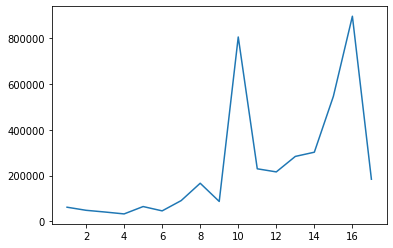

In [ ]:
plt.plot(range(1,len(perplexities)+1),perplexities)
plt.show()

Now measure the space saving amount of the trained model on the test text.
Also check that when you decompress the compressed test text you get exactly the same string as the test text.

In [ ]:
print(space_saved(model,test_str))

Now we'll analyse the model a bit.
Split the test text into sentences and compress each individual sentence.
Print out the top 5 most compressed sentences and the top 5 least compressed sentences according to the space saving metric together with the compressed sentences.

In [ ]:
test_sentences = test_str.split('\n')

In [ ]:
space_saved_test = {}

for test_sent in test_sentences[:50]:

  compressed_sent = compress(model,test_sent)
  space_saved_test[compressed_sent] = space_saved(model,test_sent)

sort_space_saved_test = sorted(space_saved_test.items(), key=lambda x: x[1], reverse=True)

print("Top 5 compressed")
display(sort_space_saved_test[:5])

print("Least 5 compressed")
display(sorted(sort_space_saved_test[-5:], key=lambda x: x[1], reverse=False))


Can we explain this difference in compression using sentences' similarities to the train set?
Extract all the trigrams from each of the test sentences and, for each sentence, count how many of its trigrams are also found in the train set.
Divide this count by the number of trigrams in the sentence in order to have a domain similarity measure.
In order for the fraction to be meaningful from the language model's point of view, the edge token must be added to the front of the test sentences and out-of-vocabulary tokens must be replaced with the unknown token.
Plot a scatter plot showing how this domain similarity measure relates to the space saving amount of each test sentence.

In [ ]:
def extract_ngrams(tokenized_sent, num):
    n_grams = nltk.ngrams(tokenized_sent, num)
    return [ ' '.join(grams) for grams in n_grams]

In [ ]:
test_trigrams = []
for tok_test_sentence in test_pd['tok_text']:
  test_trigrams.append(extract_ngrams(tok_test_sentence,3))

train_trigrams = []
for tok_train_sentence in train_pd['tok_text']:
  train_trigrams.append(extract_ngrams(tok_train_sentence,3))

print(test_pd['tok_text'] == train_pd['tok_text'])

If the domain similarity measure we used was enough for explaining the compressibility, the above plot would look a bit like a straight line.
Why is domain similarity not enough for explaining the compressability?

## Conclusions (10%)

Write the following conclusions:

What is a simple change in the compression algorithm that can be made to increase compression?
Do not suggest any fundamental changes; the algorithm must still work by predicting missing tokens.

Write, in less than 300 words, your interpretation of the results and how you think the model could perform better.
You should talk about things like overfitting/underfitting and whether the model is learning anything deep about English sentences.